# 数据读取

In [1]:
#导入PySAL的子模块libpysal
import libpysal 
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd

## 数据读取与整理

In [2]:
#读取共享单车停车数据
data_stop = pd.read_csv(r'data/bicycle_points.csv')
data_stop.head(5)

,lon,lat
0,121.472519,31.273511
1,121.479947,31.258949
2,121.485236,31.266860
3,121.488845,31.290549
4,121.489748,31.290124


In [3]:
#数据进行栅格化集计
#定义范围，获取栅格化参数
lat1sh = 30.9666667;
lat2sh = 31.4833333;
lon1sh = 121.166667;
lon2sh = 121.9;
bounds = [lon1sh,lat1sh,lon2sh,lat2sh]
params = tbd.grid_params(bounds,accuracy = 500)
#将GPS栅格化
data_stop['LONCOL'],data_stop['LATCOL'] = tbd.GPS_to_grids(data_stop['lon'],data_stop['lat'],params)
#统计每个栅格有多少数据量
data_count = data_stop.groupby(['LONCOL','LATCOL'])['lon'].count().rename('count').reset_index()
#生成栅格地理图形
data_count['geometry'] = tbd.gridid_to_polygon(data_count['LONCOL'],data_count['LATCOL'],params)
#转为GeoDataFrame
data_count = gpd.GeoDataFrame(data_count)
data_count.head(5)

,LONCOL,LATCOL,count,geometry
0,58,68,1,"POLYGON ((121.46902 31.27019, 121.47428 31.270..."
1,59,69,1,"POLYGON ((121.47428 31.27468, 121.47954 31.274..."
2,59,71,2,"POLYGON ((121.47428 31.28368, 121.47954 31.283..."
3,59,72,1,"POLYGON ((121.47428 31.28817, 121.47954 31.288..."
4,59,74,1,"POLYGON ((121.47428 31.29717, 121.47954 31.297..."


<AxesSubplot:>

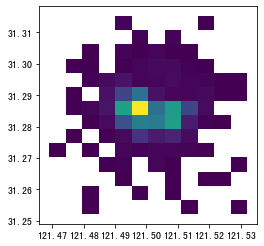

In [4]:
data_count.plot(column = 'count')

In [5]:
#转换投影坐标系以便以距离计算空间权重
data_count.crs = {'init':'epsg:4326'}
data_count_2416 = data_count.to_crs(epsg = '2416')

/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
data = data_count_2416.copy()

# 空间自相关

## 全局莫兰指数

In [12]:
import esda
#获取空间关系权重
wq = libpysal.weights.KNN.from_dataframe(data,k=10)
#每个矢量图形自身的权重
weight = data['count']
#应用方法
lisa_moran = esda.moran.Moran(weight,wq)
#得到结果
lisa_moran.I,lisa_moran.z_norm,lisa_moran.p_sim

(0.4478528485202218, 11.160701607129226, 0.001)

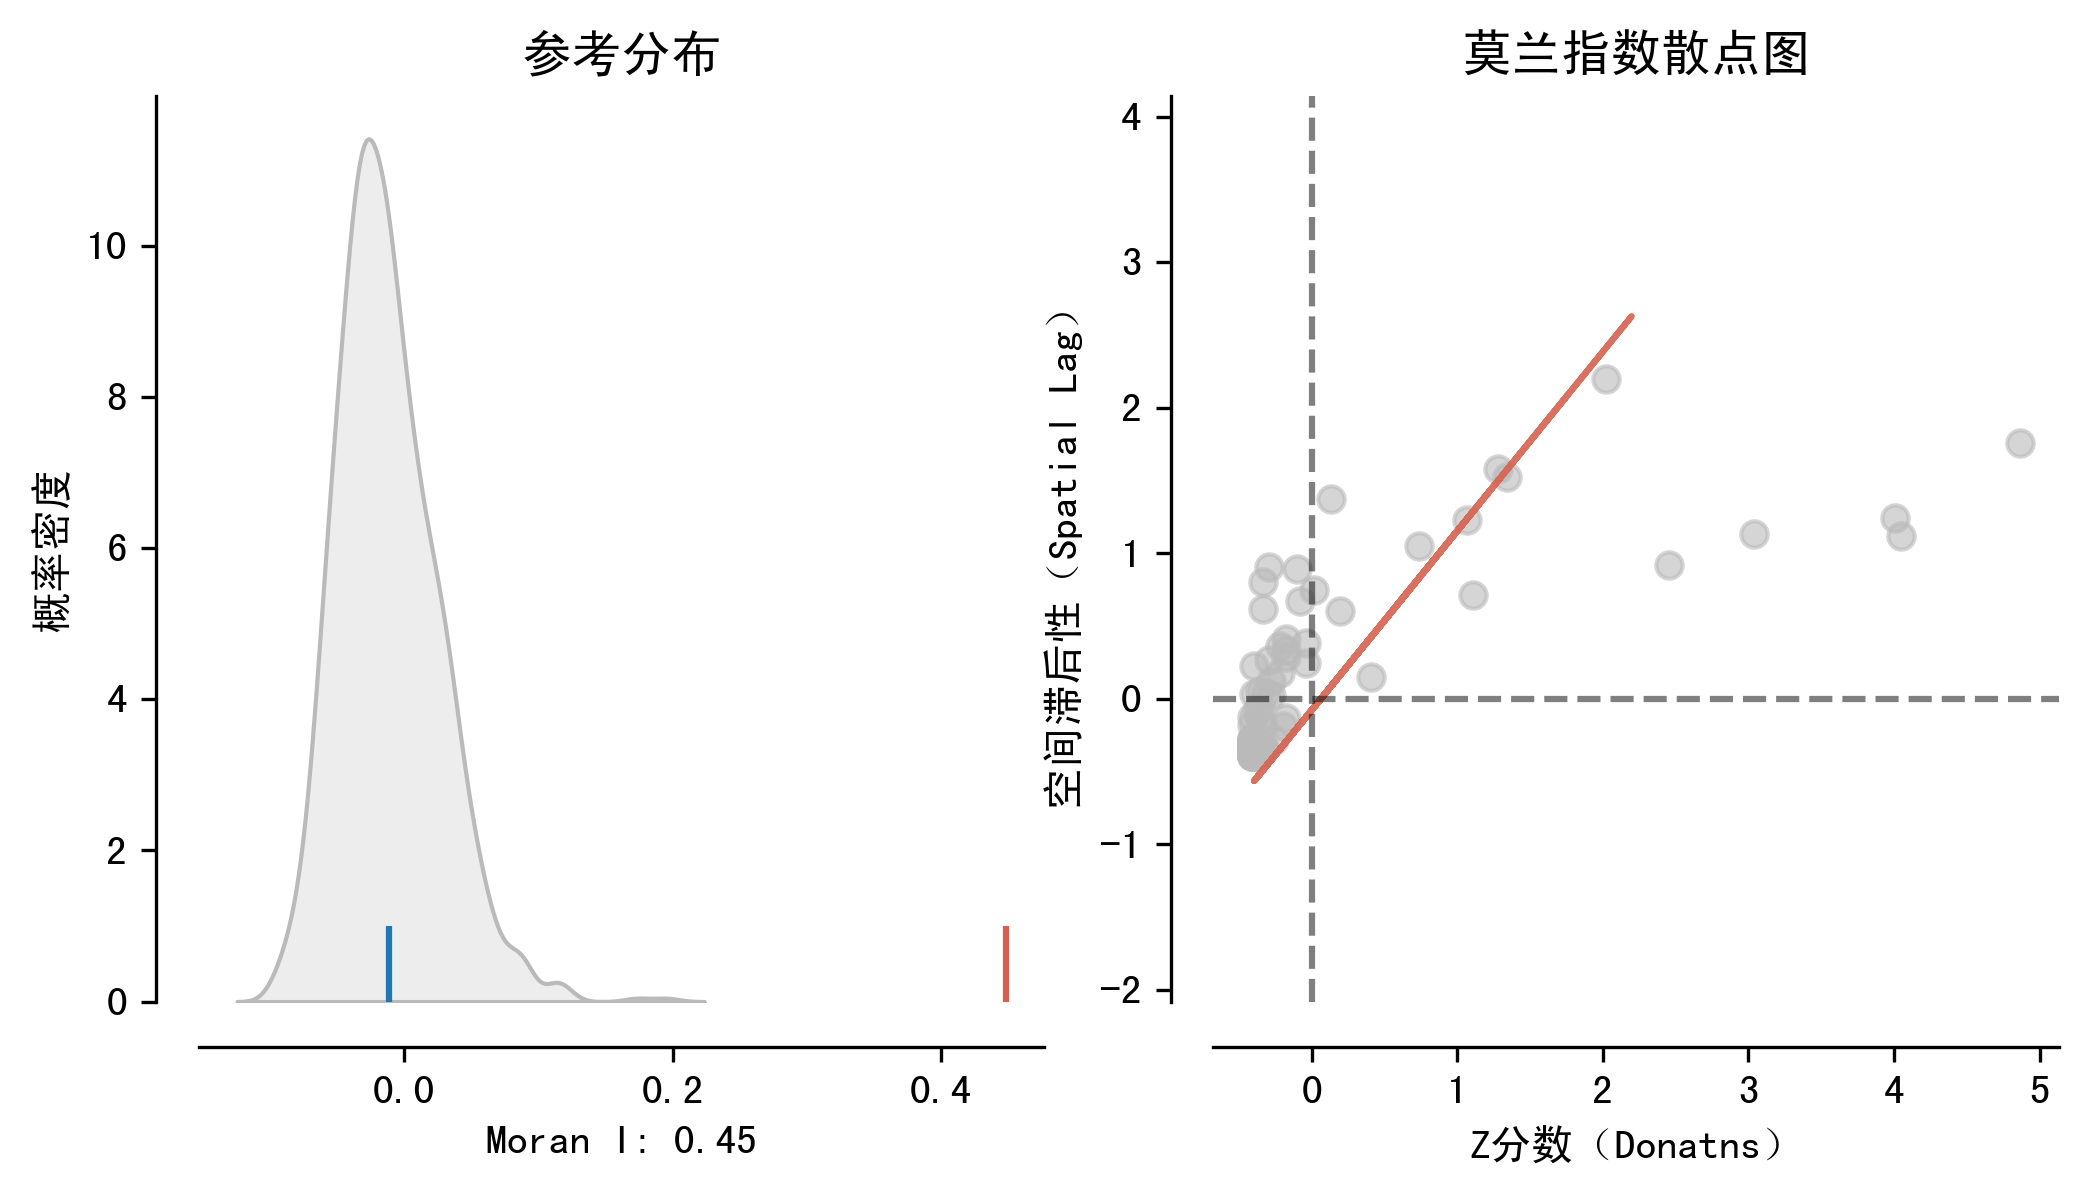

In [13]:
import matplotlib.pyplot as plt
#绘制空间自相关的信息
from splot.esda import plot_moran
fig,ax = plot_moran(lisa_moran, zstandard=True)
#设置图表标题
ax[0].set_ylabel('概率密度')
ax[0].set_title('参考分布')
ax[1].set_xlabel('Z分数（Donatns）')
ax[1].set_ylabel('空间滞后性（Spatial Lag）')
ax[1].set_title('莫兰指数散点图')
#设置图表大小
fig.set_size_inches(8,4)
fig.set_dpi(300)
plt.show()

## 局部莫兰指数

In [14]:
#应用方法
lisa_moran_local = esda.moran.Moran_Local(weight,wq)
#得到每个矢量要素的结果
data['Is'] = lisa_moran_local.Is
data['z'] = lisa_moran_local.z_sim
data['p'] = lisa_moran_local.p_sim
data['q'] = lisa_moran_local.q
data

,LONCOL,LATCOL,count,geometry,Is,z,p,q
0,1616,1973,1,"POLYGON ((40640065.194 3461833.246, 40640529.2...",0.152624,1.237892,0.017,3
1,1616,1975,1,"POLYGON ((40640051.899 3462830.513, 40640515.9...",0.139100,1.129390,0.089,3
2,1616,1977,1,"POLYGON ((40640038.600 3463827.781, 40640502.6...",0.147055,1.193214,0.047,3
3,1617,1969,1,"POLYGON ((40640555.955 3459844.910, 40641020.1...",0.161375,1.308099,0.003,3
4,1617,1970,1,"POLYGON ((40640549.289 3460343.543, 40641013.4...",0.161375,1.308099,0.003,3
...,...,...,...,...,...,...,...,...
87,1627,1969,1,"POLYGON ((40645197.772 3459907.985, 40645661.9...",0.161375,1.329127,0.003,3
88,1627,1977,1,"POLYGON ((40645142.658 3463897.096, 40645606.6...",0.135917,1.129007,0.112,3
89,1628,1973,1,"POLYGON ((40645634.319 3461908.960, 40646098.4...",0.140691,1.166530,0.079,3
90,1628,1977,1,"POLYGON ((40645606.666 3463903.520, 40646070.6...",0.135917,1.129007,0.112,3


In [15]:
?moran_scatterplot

Object `moran_scatterplot` not found.


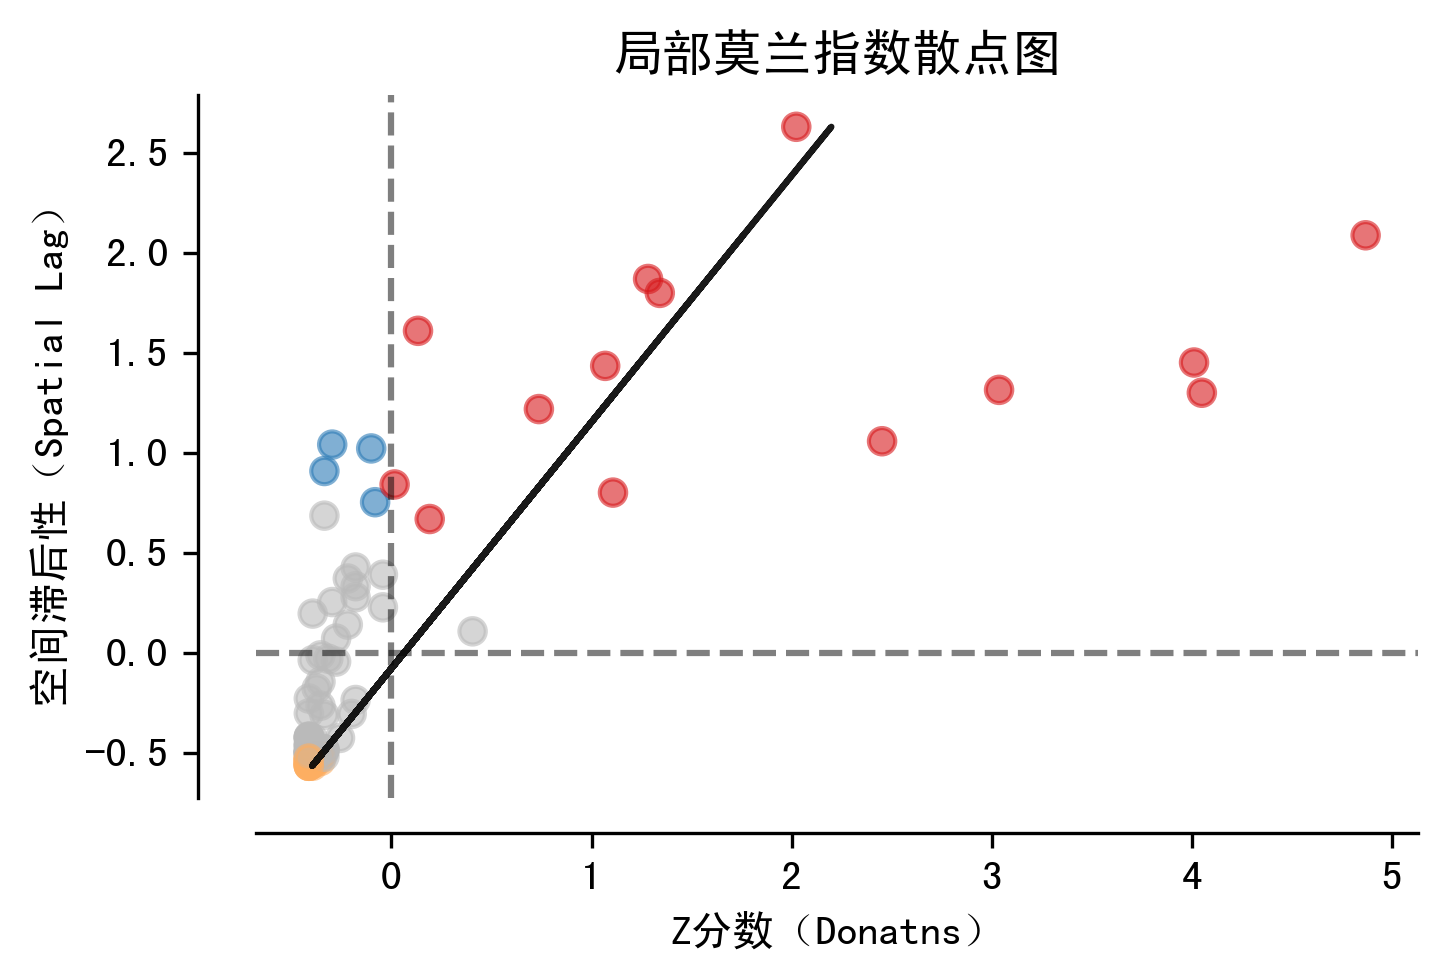

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(1,(5,5),dpi = 300)
ax = plt.subplot(111)
#可视化局部空间自相关的分析结果
from splot.esda import moran_scatterplot
moran_scatterplot(lisa_moran_local, p=0.05,ax = ax)
ax.set_xlabel('Z分数（Donatns）')
ax.set_ylabel('空间滞后性（Spatial Lag）')
plt.title('局部莫兰指数散点图')
plt.show()

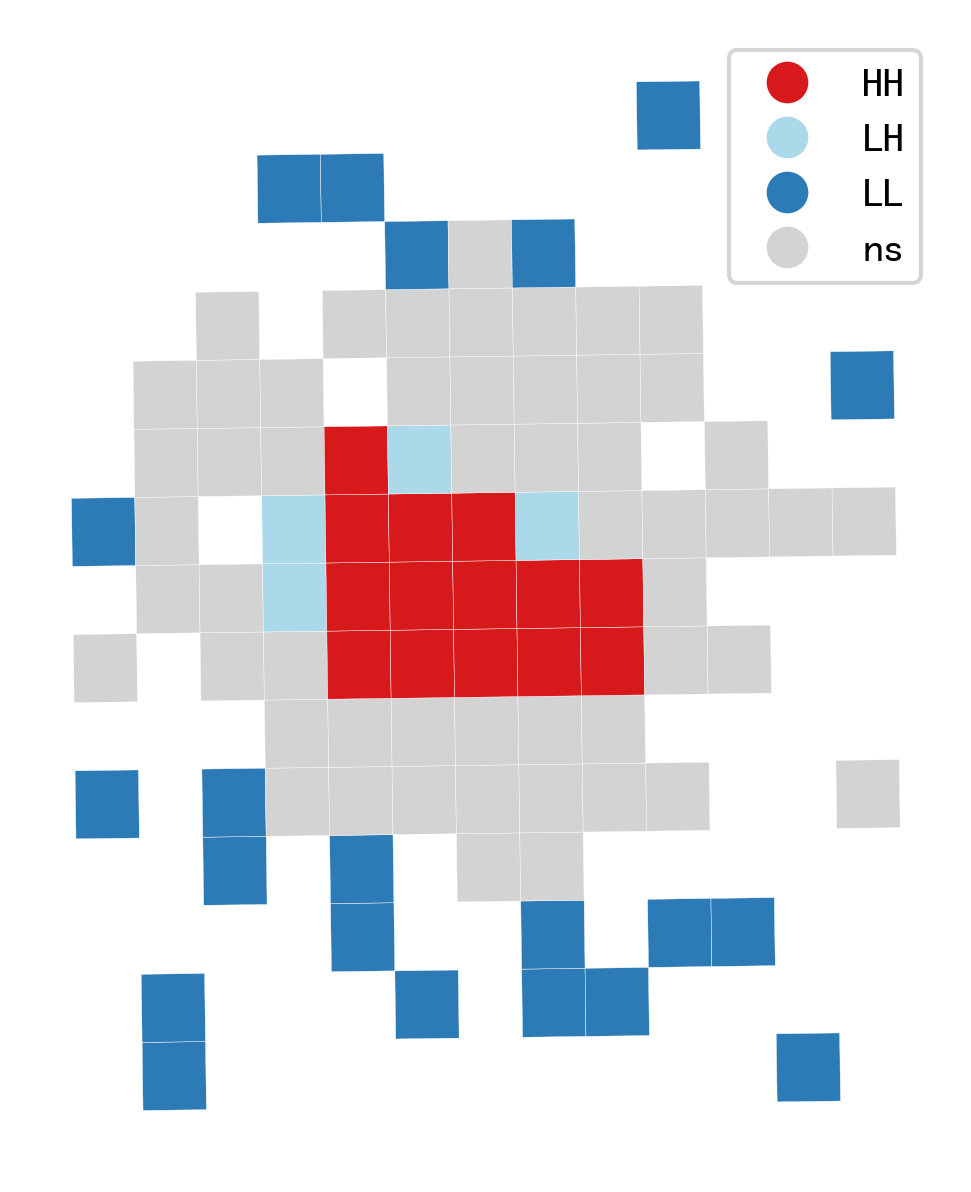

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(1,(5,5),dpi = 300)
ax = plt.subplot(111)
#绘制局部莫兰指数的分类结果
from splot.esda import lisa_cluster
lisa_cluster(lisa_moran_local, data, p=0.05,ax = ax)
plt.show()

# 热点分析

## 全局G指数

In [18]:
data = data_count_2416.copy()
#全局G指数
lisa_G = esda.getisord.G(weight,wq)
#得到结果
lisa_G.G,lisa_G.p_sim

/opt/anaconda3/lib/python3.8/site-packages/esda/getisord.py:164: RuntimeWarning: overflow encountered in long_scalars
  EG2DEN = ((sum(y) ** 2 - sum(y2)) ** 2) * n * (n - 1) * (n - 2) * (n - 3)
/opt/anaconda3/lib/python3.8/site-packages/esda/getisord.py:119: RuntimeWarning: invalid value encountered in sqrt
  self.z_norm = (self.G - self.EG) / np.sqrt(self.VG)


(0.4135468206399256, 0.001)

## 局部G指数

In [19]:
#局部G指数
lisa_G_local = esda.getisord.G_Local(weight,wq)
#获得每个空间要素的G
data['Gs'] = lisa_G_local.Gs
data['z'] = lisa_G_local.z_sim
data['p'] = lisa_G_local.p_sim
#标记显著热点
data.loc[(data['p']<0.05)&(data['z']>0),'hotspot'] = 1
#标记显著冷点
data.loc[(data['p']<0.05)&(data['z']<0),'hotspot'] = 0
data

,LONCOL,LATCOL,count,geometry,Gs,z,p,hotspot
0,1616,1973,1,"POLYGON ((40640065.194 3461833.246, 40640529.2...",0.001471,-1.274184,0.031,0.0
1,1616,1975,1,"POLYGON ((40640051.899 3462830.513, 40640515.9...",0.002304,-1.109595,0.084,NaN
2,1616,1977,1,"POLYGON ((40640038.600 3463827.781, 40640502.6...",0.001814,-1.200201,0.039,0.0
3,1617,1969,1,"POLYGON ((40640555.955 3459844.910, 40641020.1...",0.000931,-1.326063,0.002,0.0
4,1617,1970,1,"POLYGON ((40640549.289 3460343.543, 40641013.4...",0.000931,-1.263978,0.006,0.0
...,...,...,...,...,...,...,...,...
87,1627,1969,1,"POLYGON ((40645197.772 3459907.985, 40645661.9...",0.000931,-1.313523,0.005,0.0
88,1627,1977,1,"POLYGON ((40645142.658 3463897.096, 40645606.6...",0.002500,-1.100087,0.105,NaN
89,1628,1973,1,"POLYGON ((40645634.319 3461908.960, 40646098.4...",0.002206,-1.149819,0.093,NaN
90,1628,1977,1,"POLYGON ((40645606.666 3463903.520, 40646070.6...",0.002500,-1.186742,0.102,NaN


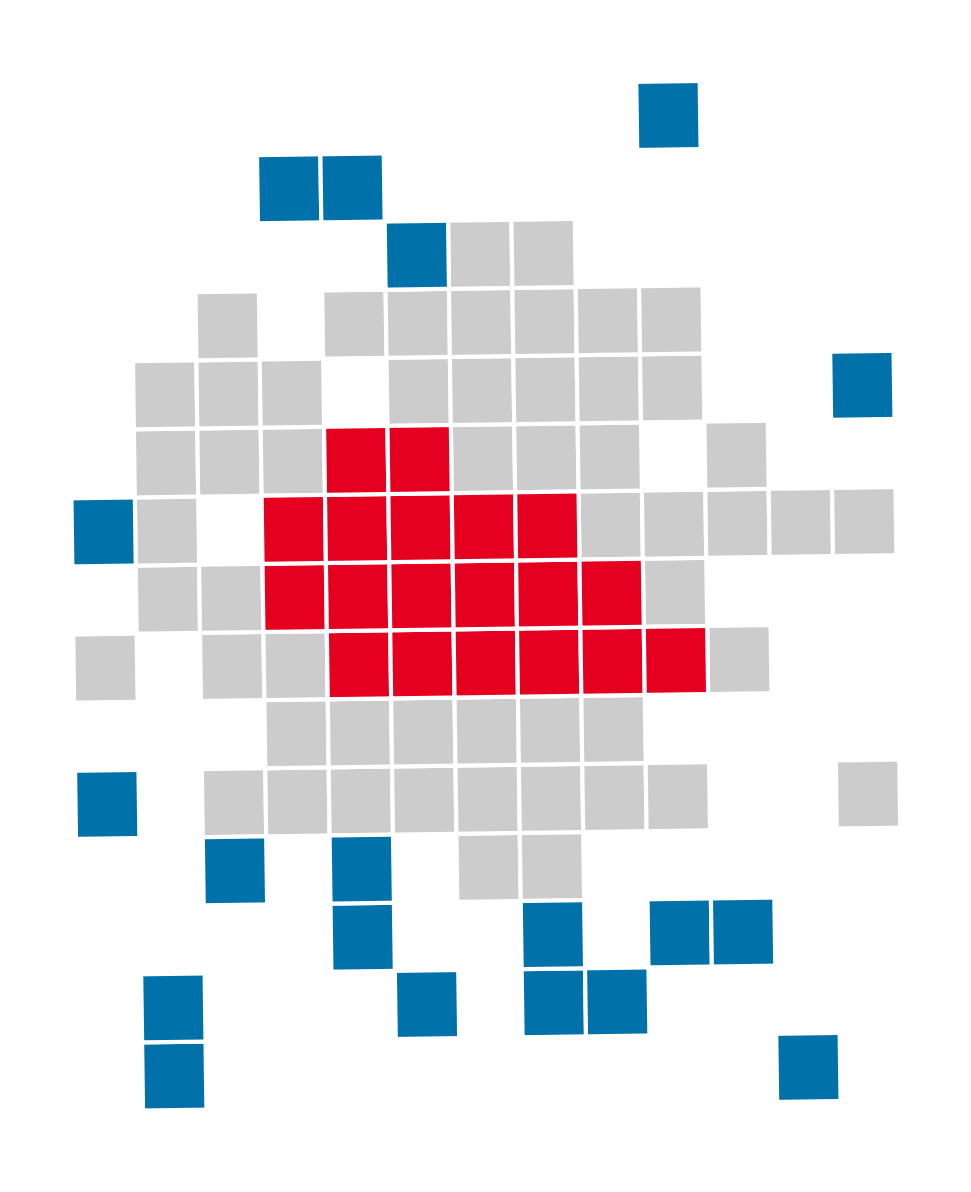

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(1,(5,5),dpi = 300)
ax = plt.subplot(111)
#绘制所有空间要素
data.plot(ax = ax,facecolor = (0.8,0.8,0.8),edgecolor = (1,1,1))
#绘制冷点
data[data['hotspot'] == 0].plot(ax = ax,facecolor = '#0072a9',edgecolor = (1,1,1))
#绘制热点
data[data['hotspot'] == 1].plot(ax = ax,facecolor = '#e5001f',edgecolor = (1,1,1))
plt.axis('off')
plt.show()